In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import book_format
book_format.load_style(name='/styles/custom4.css')

## Optimization using Simulated Annealing

Annealing is a metallurgic process that involves heating a material beyond its critical temperature, maintaining a suitable temperature, and then cooling. If the process is followed according to a schedule appropriate to the material, annealing increases its ductility and reduces the number of defects. ***Simulated annealing*** uses an analogous process to pursue an optimial solution of a function over a large search space, in the sense that at high  "temperatures" (large probabilities) solutions are proposed from more distant regions of the  parameter space relative to the current solution. Similarly, "cooling" slowly reduces the number of exploratory proposals in order to converge on a (hopefully) global optimum. Thus, there is an initial period of liberal exploration, which gradually decreases to resemble hill-climbing procedures that we have already seen.

A generic simulated annealing algorithm proceeds as follows:

1. Initialize $t=0$, $\theta^{(t=0)}$, temperature $\tau^{(0)}$
2. Iterate until convergence:

    a. Select candidate solution $\theta^{\prime}$ from neighborhood of $\theta^{(t)}$ 
    according to proposal g($\theta^{(t)})$  
    b. Set $\theta^{(t+1)} = \theta^{\prime}$ with probability:
    
    $$\alpha = \min\left(1, \exp\left[\frac{f(\theta^{(t)})-f(\theta^{\prime})}{\tau^{(j)}}\right]\right)$$
    
    otherwise, set $\theta^{(t+1)} = \theta^{(t)}$  
    c. Repeat (a) and (b) for $m_j$ iterations  
    d. Increment $j$, update $\tau^{(j)}$ and $m_j$ according to cooling schedule
    
This algorithm can be halted once the minimum temperature is reached. The temerature $\tau^{(j)}$ should slowly decrease, while the time spent at each temperature $m_j$ should correspondingly increase.

Notice that this algorithm implies that though superior candidates are *always* adopted when proposed, inferior solutions are also accepted, but with some probability that is related to its quality relative to the current solution. This is what allows for exploration of the parameter space, and the escape from local optima.

### Proposals

A variety of proposal and neighborhood strategies can be effective, depending on the structure of the problem at hand. One constraint on generating proposed solutions is that all pairs of solutions $(\theta^{(i)}, \theta^{(j)}) \in \Theta, i \ne j$ be able to ***communicate***. That is, there must exist some finite sequence of solutions that can be generated starting at $\theta^{(i)}$ such that we eventually reach $\theta^{(j)}$.

The simplest example of a proposal strategy that allows for communication among solutions is to sample uniformly from the $k$-neighborhood of the current solution.

### Cooling and Convergence

Unlike some metaheuristics, the limiting behavior of simulated annealing is pretty well-known. Within each temperature regime, the SA algorithm produces a homogeneous Markov chain (since the transition probabilties do not change at each step), becoming non-homogeneous whenever a cooling event is triggered. If we generate symmetric proposals, such that the probability of proposing $\theta^{(i)}$ from $\theta^{(j)}$ is equal to that of proposing $\theta^{(j)}$ from $\theta^{(i)}$, then the *stationary* distribution of the Markov chain is:

$$p_{\tau}(\theta) \propto \exp[-f(\theta)/\tau]$$

So, in the limit, as we run the Markov chain, it converges to $p_{\tau}(\theta)$. During the SA algorithm, we want to run the chain long enough so that it is close to its stationary distribution before cooling. How long is "long enough" usually takes some experimentation using trial runs.

In general, we adopt a cooling schedule that sets the temperature at period $j$ according to $\tau^{(j)} = f_{\alpha}(\tau^{(j-1)})$ and the number of iterations in period $j$ according to $m_j = f_\beta(m_{j-1})$. Some specific examples include:

* $m_j = 1$ for all $j$, with very slow cooling via $\tau^{(j)} = \tau^{(j-1)}/( 1 + \alpha \tau^{(j-1)})$ for some small chosen $\alpha$
* $\tau^{(j)} = \alpha \tau^{(j-1)}$ for some $\alpha \lt 1$ with $m_j = \beta m_{j-1}$ for some $\beta \lt 1$

One approach is to choose an initial temperature $\tau^{(0)}$ so that $p$ is close to 1 for all combinations of $\theta^{(i)}$ and $\theta^{(j)}$, which provides any point a reasonable chance of being visited early in the simulation. 

The appropriate choice for $m_j$ is a tradeoff between performance and speed: a large number of steps can produce a more accurate solution, but requires additional computation. Evidence suggests that long runs at high temperatures is not optimal. For most problems, good cooling schedules invlove a rapid decrease in temperature early in the simulation.

## Tree Farming Problem

Set up the problem by specifying the age-specific tree prices, and all the expense types.

In [2]:
tree_price = np.array([0, 0, 0, 0, 20, 30, 50, 60, 65])

expenses = pd.DataFrame({'planting': [100] + [0]*8,
                        'mow_spray': [8]*6 + [0]*3,
                        'trimming': [0]*5 + [7,7,7,0],
                        'cutting': [0]*4 + [5]*5,
                        'machinery': [25]*9,
                        'labor': [21, 12, 12, 12, 14, 17, 8, 8, 5],
                        'clerical': [7]*9})
expenses

,clerical,cutting,labor,machinery,mow_spray,planting,trimming
0,7,0,21,25,8,100,0
1,7,0,12,25,8,0,0
2,7,0,12,25,8,0,0
3,7,0,12,25,8,0,0
4,7,5,14,25,8,0,0
5,7,5,17,25,8,0,7
6,7,5,8,25,0,0,7
7,7,5,8,25,0,0,7
8,7,5,5,25,0,0,0


## Constraints

- Cannot sell any trees until year 5
- Initial costs spread evenly over last 5 years
- Income of each year 5-9 to cover expenditures
- All trees must be sold by time horizon

Here is an arbitrary starting policy that we will attempt to improve, using simulated annealing. It simply allocates the total trees evenly among the final 5 years.

In [3]:
initial_policy = [26480/5]*5
initial_policy

[5296.0, 5296.0, 5296.0, 5296.0, 5296.0]

In [4]:
def value_function(policy, debug=False):
    
    p = np.append([0]*4, policy)
    
    trees_planted = 26480
    
    # State variable is number of trees in each year
    trees_start = [trees_planted - sum(p[:i]) for i in range(len(p))]
    trees_left = [trees_planted - sum(p[:i+1]) for i in range(len(p))]
    if debug: print('Trees at start of season:', trees_start)
    
    
    # Calculate income from selling trees according to policy
    annual_income = tree_price * p
    if debug: print('Income:', annual_income)
        
    mowing_cost = expenses.mow_spray.values * trees_start/100
    if debug: print('Mowing & Spraying:', mowing_cost)
    
    trimming_cost = expenses.trimming.values * trees_start/100
    if debug: print('Trimming:', trimming_cost)
    
    cutting_cost = expenses.cutting.values * p/100
    if debug: print('Cutting:', cutting_cost)
        
    machinery_cost = expenses.machinery.values * trees_start/100
    if debug: print('Machinery:', machinery_cost)
        
    labor_cost = expenses.labor.values * trees_start/100
    if debug: print('Labor:', labor_cost)
        
    clerical_cost = expenses.clerical.values * trees_start/100
    if debug: print('Clerical:', clerical_cost)
        
    annual_costs = mowing_cost + trimming_cost + cutting_cost + machinery_cost + labor_cost + clerical_cost
    if debug: print('Annual costs:', annual_costs)
        
    deferred_costs = annual_costs[:4].sum() + trees_planted
    if debug: print('Startup costs:', deferred_costs)
        
    last_5_costs = annual_costs[4:] + deferred_costs/4
    if debug: print('Expenses in last 5:', last_5_costs)
        
    if (last_5_costs > annual_income[4:]).any():
        if debug: print('Costs exceeded income in at least one year')
        return 0
        
    profit = annual_income.sum() - last_5_costs.sum()
    if debug: print('Profit is', profit)
        
    return profit

Here is the value function for the initial policy, with the `debug` flag turned on to report intermediate results.

In [5]:
value_function(initial_policy, debug=True)

Trees at start of season: [26480, 26480.0, 26480.0, 26480.0, 26480.0, 21184.0, 15888.0, 10592.0, 5296.0]
Income: [      0.       0.       0.       0.  105920.  158880.  264800.  317760.
  344240.]
Mowing & Spraying: [ 2118.4   2118.4   2118.4   2118.4   2118.4   1694.72     0.       0.
     0.  ]
Trimming: [    0.       0.       0.       0.       0.    1482.88  1112.16   741.44
     0.  ]
Cutting: [   0.     0.     0.     0.   264.8  264.8  264.8  264.8  264.8]
Machinery: [ 6620.  6620.  6620.  6620.  6620.  5296.  3972.  2648.  1324.]
Labor: [ 5560.8   3177.6   3177.6   3177.6   3707.2   3601.28  1271.04   847.36
   264.8 ]
Clerical: [ 1853.6   1853.6   1853.6   1853.6   1853.6   1482.88  1112.16   741.44
   370.72]
Annual costs: [ 16152.8   13769.6   13769.6   13769.6   14564.    13822.56   7732.16
   5243.04   2224.32]
Startup costs: 83941.6
Expenses in last 5: [ 35549.4   34807.96  28717.56  26228.44  23209.72]
Profit is 1043086.92


1043086.9199999999

## Simulated annealing solution

We set up the algorithm by setting up the cooling schedule.

In [6]:
periods = 150
cooling = [100]*int(periods/3) + [10]*int(periods/3) + [2]*int(periods/3)
tau_start = 10
tau = [tau_start]*periods

The simulated annealing procedure:

In [7]:
current_policy = initial_policy
best_policy = current_policy[:]
best_value = 0
value_trace = [best_value]

for j in range(periods):
    
    for i in range(cooling[j]):
        
        step_policy = current_policy[:]
        
        # Pick random years to move trees from and to
        from_year, to_year = np.random.randint(5, size=2)
        while from_year==to_year:
            from_year, to_year = np.random.randint(5, size=2)
            
        step_policy[to_year] += i
        step_policy[from_year] -= i
        
        value = value_function(step_policy)
        
        alpha = min(1, np.exp((value - value_trace[-1])/tau[j]))
        
        if ((value > value_trace[-1]) or (np.random.uniform() < alpha)):
            # Accept proposed solution
            current_policy = step_policy[:]
            value_trace.append(value)
            if value > best_value:
                # Replace previous best with this one
                best_value = value
                best_policy = step_policy[:]
        else:
            # Retain current solution
            value_trace.append(value_trace[-1])

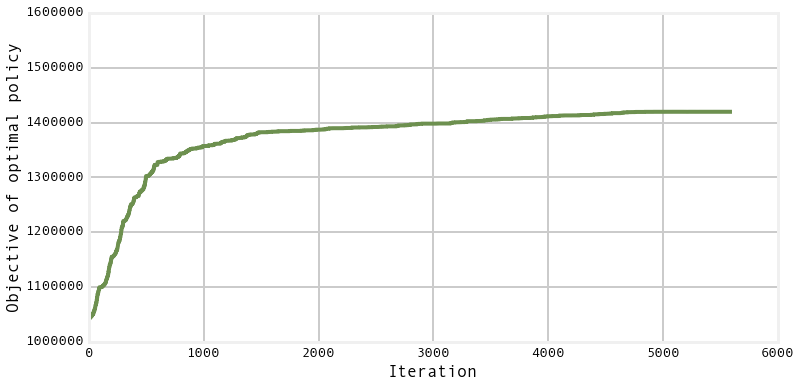

In [8]:
pl.plot(value_trace)
pl.ylim(1000000, 1600000)
pl.ylabel('Objective of optimal policy'); pl.xlabel('Iteration');

The estimated best policy.

In [9]:
best_policy

[1769.0, 1229.0, 642.0, 530.0, 22310.0]

The value of the estimated best policy.

In [10]:
int(best_value)

1419908

The value function, evaluated at the best policy.

In [11]:
value_function([1559, 1094, 561, 463, 22803], True)

Trees at start of season: [26480, 26480, 26480, 26480, 26480, 24921, 23827, 23266, 22803]
Income: [      0       0       0       0   31180   32820   28050   27780 1482195]
Mowing & Spraying: [ 2118.4   2118.4   2118.4   2118.4   2118.4   1993.68     0.       0.
     0.  ]
Trimming: [    0.       0.       0.       0.       0.    1744.47  1667.89  1628.62
     0.  ]
Cutting: [    0.       0.       0.       0.      77.95    54.7     28.05    23.15
  1140.15]
Machinery: [ 6620.    6620.    6620.    6620.    6620.    6230.25  5956.75  5816.5
  5700.75]
Labor: [ 5560.8   3177.6   3177.6   3177.6   3707.2   4236.57  1906.16  1861.28
  1140.15]
Clerical: [ 1853.6   1853.6   1853.6   1853.6   1853.6   1744.47  1667.89  1628.62
  1596.21]
Annual costs: [ 16152.8   13769.6   13769.6   13769.6   14377.15  16004.14  11226.74
  10958.17   9577.26]
Startup costs: 83941.6
Expenses in last 5: [ 35362.55  36989.54  32212.14  31943.57  30562.66]
Costs exceeded income in at least one year


0